In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

['resources.csv', 'train.csv', 'test.csv', 'sample_submission.csv']


In [77]:
train_test_dtypes = {'id':str, 'teacher_id':str, 'teacher_prefix':str, 'school_state':str, 'project_submitted_datetime':str, 'project_grade_category':str, 'project_subject_categories':str,
                     'project_subject_subcategories':str, 'project_title':str, 'project_essay_1':str, 'project_essay_2':str, 'project_essay_3':str, 'project_essay_4':str, 'project_resource_summary':str, 
                     'teacher_number_of_previously_posted_projects':int, 'project_is_approved':int}

In [78]:
train_data_raw = pd.read_csv('../input/train.csv', sep=',', dtype=train_test_dtypes, low_memory=True)
test_data_raw = pd.read_csv('../input/test.csv', sep=',', dtype=train_test_dtypes, low_memory=True)
resource_data_raw = pd.read_csv('../input/resources.csv', sep=',')

In [79]:
train_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [80]:
test_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78035 entries, 0 to 78034
Data columns (total 15 columns):
id                                              78035 non-null object
teacher_id                                      78035 non-null object
teacher_prefix                                  78034 non-null object
school_state                                    78035 non-null object
project_submitted_datetime                      78035 non-null object
project_grade_category                          78035 non-null object
project_subject_categories                      78035 non-null object
project_subject_subcategories                   78035 non-null object
project_title                                   78035 non-null object
project_essay_1                                 78035 non-null object
project_essay_2                                 78035 non-null object
project_essay_3                                 2704 non-null object
project_essay_4                                 2704

In [81]:
resource_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541272 entries, 0 to 1541271
Data columns (total 4 columns):
id             1541272 non-null object
description    1540980 non-null object
quantity       1541272 non-null int64
price          1541272 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 47.0+ MB


In [82]:
cat_features = ['project_grade_category', 'project_subject_categories', 'project_subject_subcategories', 'teacher_prefix', 'school_state']
text_features = ['project_title', 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4', 'project_resource_summary']
temp_text_features1 = ['project_title', 'project_essay_1', 'project_essay_2']
temp_text_features2 = ['project_essay_3', 'project_essay_4', 'project_resource_summary']

Visualizations of the first 2 rows of categorical data in the training dataset

In [83]:
train_data_raw[cat_features].head(2)

,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_prefix,school_state
0,Grades PreK-2,Literacy & Language,Literacy,Ms.,NV
1,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Mrs.,GA


Visualizations of the first 2 rows of numeric data from the resources dataset

In [84]:
resource_data_raw.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


Visualizations of the first 2 rows of text data in the training dataset

In [85]:
train_data_raw[text_features].head(2)

,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary
0,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...
1,Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...


Change the project_submitted_datetime column to type datetime64, and extract year and month as new features

In [86]:
train_data_raw['year'] = train_data_raw.project_submitted_datetime.apply(lambda x: x.split("-")[0])
train_data_raw['month'] = train_data_raw.project_submitted_datetime.apply(lambda x: x.split("-")[1])
train_data_raw['project_submitted_datetime'] = pd.to_datetime(train_data_raw['project_submitted_datetime'], format="%Y-%m-%d %H:%M:%S")
test_data_raw['year'] = test_data_raw.project_submitted_datetime.apply(lambda x: x.split("-")[0])
test_data_raw['month'] = test_data_raw.project_submitted_datetime.apply(lambda x: x.split("-")[1])
test_data_raw['project_submitted_datetime'] = pd.to_datetime(test_data_raw['project_submitted_datetime'], format="%Y-%m-%d %H:%M:%S")

There seems to be a spike in proposal submissions in August and September, the beginning of the school year

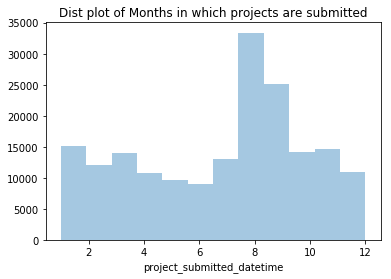

In [87]:
sns.distplot(train_data_raw.project_submitted_datetime.dt.month, kde=False, bins=12)
plt.title("Dist plot of Months in which projects are submitted");

There is an imbalance in the dataset betwen approved and rejected project proposals. In the training dataset, 154,346 (85%) proposals were approved, 27,734 were rejected, 

1    154346
0     27734
Name: project_is_approved, dtype: int64

Percentage of proposals approved = 0.8476823374340949%


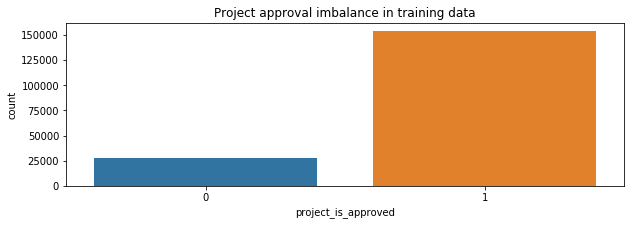

In [88]:
print(train_data_raw['project_is_approved'].value_counts())
print("\nPercentage of proposals approved = {}%".format(train_data_raw['project_is_approved'].value_counts()[1] / len(train_data_raw['project_is_approved'])))
plt.figure(figsize=(10,3));
plt.title('Project approval imbalance in training data')
sns.countplot(x=train_data_raw['project_is_approved']);

**EDA of numeric features**

In [89]:
resource_data_raw['total'] = resource_data_raw['quantity'] * resource_data_raw['price']
resource_data_raw.head()

,id,description,quantity,price,total
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95,44.85
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59,27.18
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95,74.85


In [90]:
totals_by_prop_id = resource_data_raw[['id', 'total']].groupby('id').total.agg(sum)
print("Max proposal amount request: {}".format(totals_by_prop_id.max()))
print("Min proposal amount request: {}".format(totals_by_prop_id.min()))
print("Avg proposal amount request: {}".format(totals_by_prop_id.mean()))
print("Median proposal amount request: {}".format(totals_by_prop_id.median()))

Max proposal amount request: 17901.94
Min proposal amount request: 100.0
Avg proposal amount request: 544.8816128250276
Median proposal amount request: 397.4200000000001


In [91]:
resource_data_raw[['id', 'price']].groupby('id').max().max()

price    9999.0
dtype: float64

In [92]:
res = resource_data_raw[['id', 'total']].groupby('id').total.agg(\
    [
        'count', 
        'sum', 
        'min', 
        'max', 
        'mean', 
        'median',
        'std',
    ]).reset_index()
print(res.head())

        id  count      sum    min     max        mean   median         std
0  p000001      4   833.63  47.98  522.16  208.407500  131.745  216.187374
1  p000002     14   630.28   9.95  134.90   45.020000   34.995   32.205568
2  p000003      4   298.97  39.99  169.00   74.742500   44.990   63.014906
3  p000004     95  1126.22   3.20  401.54   11.854947    7.290   40.594460
4  p000005      4   702.31  54.08  323.75  175.577500  162.240  111.164308


In [93]:
train_data_raw = train_data_raw.merge(res, on='id')
test_data_raw = test_data_raw.merge(res, on='id')

In [94]:
train_data_raw[train_data_raw.isnull().any(axis=1)].head(2)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,...,project_is_approved,year,month,count,sum,min,max,mean,median,std
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,...,1,2016,11,2,899.94,449.97,449.97,449.97,449.97,0.0
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,...,0,2017,04,1,400.00,400.00,400.00,400.00,400.00,NaN


Some of the STDDEV values end up being NAN. These values occurred when there was only one resource requested of quantity 1. Fill these STDDEV NAN values with 0.0

In [95]:
values = {'std': 0.0}
train_data_raw.fillna(value=values, inplace=True)
test_data_raw.fillna(value=values, inplace=True)

Max and average sums of rejected and approved projects

In [96]:
print('Max sum requested for rejected and approved proposals.')
train_data_raw[['project_is_approved', 'sum']].groupby('project_is_approved').max().rename(columns={'sum':'max'})

Max sum requested for rejected and approved proposals.


,max
project_is_approved,
0,15299.69
1,13543.82


In [97]:
print('Average sum requested for rejected and approved proposals.')
train_data_raw[['project_is_approved', 'sum']].groupby('project_is_approved').mean().rename(columns={'sum':'average'})

Average sum requested for rejected and approved proposals.


,average
project_is_approved,
0,588.449409
1,538.076234


In [98]:
print('Max number of previous proposals: approved vs. rejected')
train_data_raw[['project_is_approved','teacher_number_of_previously_posted_projects']].groupby('project_is_approved').max().rename(columns={'teacher_number_of_previously_posted_projects':'teacher_number_of_previously_posted_projects (max)'})

Max number of previous proposals: approved vs. rejected


,teacher_number_of_previously_posted_projects (max)
project_is_approved,
0,379
1,451


In [99]:
print('Average number of previous proposals: approved vs. rejected')
train_data_raw[['project_is_approved','teacher_number_of_previously_posted_projects']].groupby('project_is_approved').mean().rename(columns={'teacher_number_of_previously_posted_projects':'teacher_number_of_previously_posted_projects (avg)'})

Average number of previous proposals: approved vs. rejected


,teacher_number_of_previously_posted_projects (avg)
project_is_approved,
0,6.902791
1,12.015867


In [100]:
teacher_max_number_of_previous_proposals = train_data_raw[['teacher_id', 'teacher_number_of_previously_posted_projects']].groupby('teacher_id').teacher_number_of_previously_posted_projects.agg(max)
print("Highest number of previous proposals: {}".format(teacher_max_number_of_previous_proposals.max()))
print("Lowest number of previous proposals: {}".format(teacher_max_number_of_previous_proposals.min()))
print("Avg number of previous proposals: {}".format(teacher_max_number_of_previous_proposals.mean()))
print("Median number of previous proposals: {}".format(teacher_max_number_of_previous_proposals.median()))

Highest number of previous proposals: 451
Lowest number of previous proposals: 0
Avg number of previous proposals: 4.134752044744958
Median number of previous proposals: 1.0


The benchmark used in this project, supplied by Google's engineering education team (https://www.kaggle.com/skleinfeld/getting-started-with-the-donorschoose-data-set), theorizes that the feature teacher_number_of_previously_posted_projects may result in a higher probability of approval as a teacher has submitted more proposals, becoming more familiar with how to format their submission. The benchmark resulted in a AUROC score of 0.56522.

The next histogram/KDE plot shows that as the number of previous submissions increases, the mean approval rate also increases.

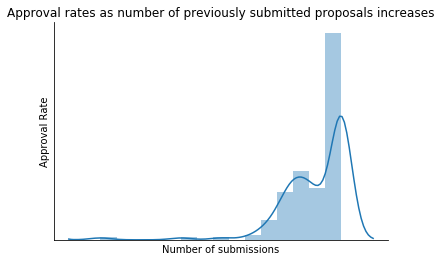

In [101]:
teacher_number_previous_submissions_mean = train_data_raw[['teacher_number_of_previously_posted_projects', 'project_is_approved']].groupby('teacher_number_of_previously_posted_projects').mean()
#sns.distplot(teacher_number_previous_submissions_mean, kde=True, bins=15);
sns.distplot(teacher_number_previous_submissions_mean['project_is_approved'], bins=15)
sns.despine()
plt.yticks([])
plt.xticks([])

plt.ylabel('Approval Rate');
plt.xlabel('Number of submissions')
plt.title('Approval rates as number of previously submitted proposals increases');

**EDA of categorical features**

In the training dataset, there are 4 NAN values in the teacher_prefix column. We will just drop these rows

In [102]:
train_data_raw.dropna(subset=['teacher_prefix'], inplace=True)

The test dataset also has 1 NAN value in the teacher_prefix column. However, we do not want to drop this row as the competition submissions expect the same number of rows (78,035) for predictions. Therefore, we will fill this NAN to be 'Teacher'

In [103]:
values = {'teacher_prefix': 'Teacher'}
test_data_raw.fillna(value=values, inplace=True)

As shown below, the number of proposals submitted for CA is very high, but drops off across states, and is low for VT and other low population states. In spite of this, the approval rate for proposals across states vary some, but not too much, remaining above 80% approval rate.

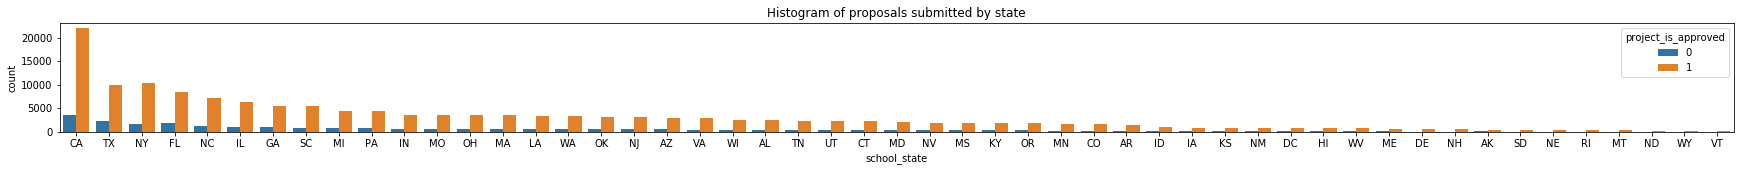

In [104]:
plt.figure(figsize=(30,2));
plt.title('Histogram of proposals submitted by state')
sns.countplot(x=train_data_raw['school_state'], order=train_data_raw['school_state'].value_counts().index, hue=train_data_raw['project_is_approved'])

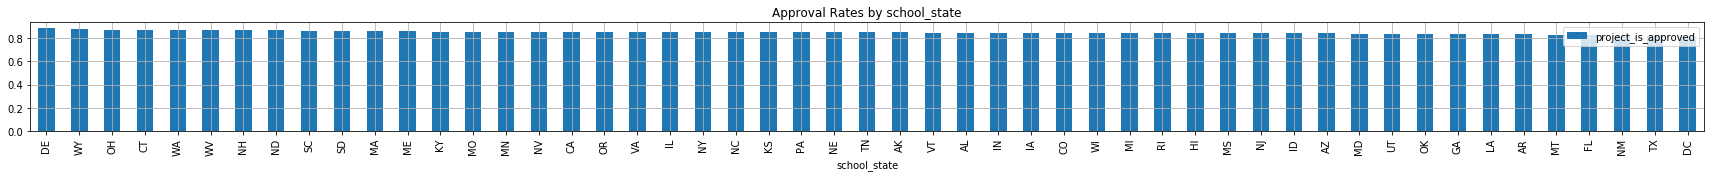

In [105]:
train_data_raw[['school_state', 'project_is_approved']].groupby('school_state').mean().sort_values(by='project_is_approved', ascending=False).plot.bar(figsize=(30,2), grid=True, title='Approval Rates by school_state');

The number of proposals varies by the type of subject categories, and the approval rates show some variance. Note that the last category which has 0 approvals only has 1 submission.

Text(0.5,1,'Histogram of proposals submitted by project_subject_categories')

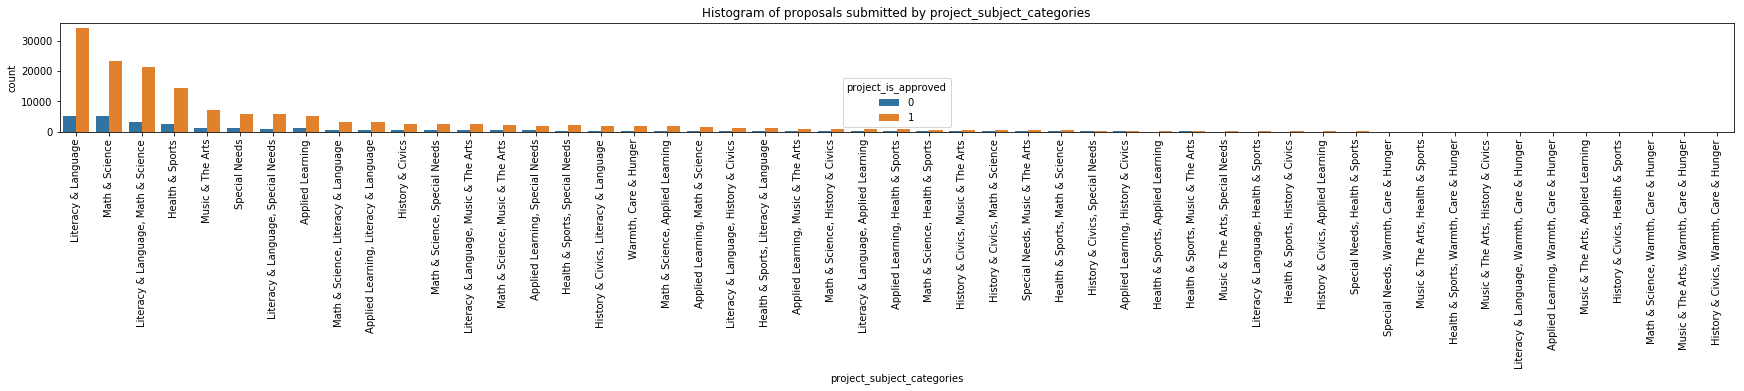

In [106]:
plt.figure(figsize=(30,2))
sns.countplot(x=train_data_raw['project_subject_categories'], hue=train_data_raw['project_is_approved'], order=train_data_raw['project_subject_categories'].value_counts().index);
plt.xticks(rotation=90);
plt.title('Histogram of proposals submitted by project_subject_categories')

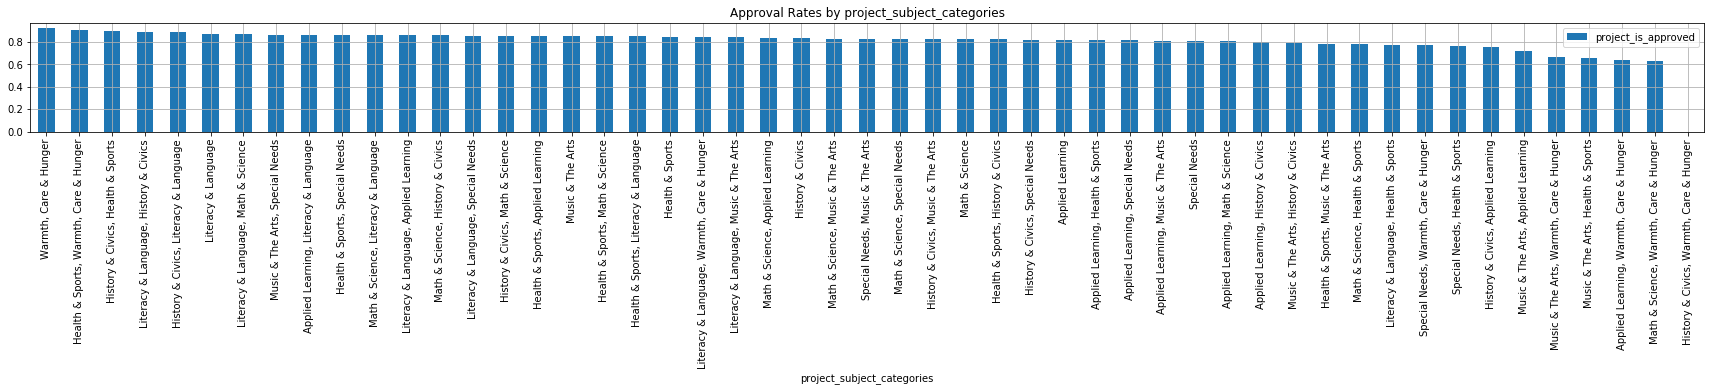

In [107]:
train_data_raw[['project_subject_categories', 'project_is_approved']].groupby('project_subject_categories').mean().sort_values(by='project_is_approved', ascending=False).plot.bar(figsize=(30,2), grid=True, title='Approval Rates by project_subject_categories');

In [108]:
train_data_raw[['project_subject_categories', 'project_is_approved']].groupby('project_subject_categories')['project_is_approved'].agg(['mean','count']).sort_values('mean', ascending=False)

,mean,count
project_subject_categories,,
"Warmth, Care & Hunger",0.921953,2191
"Health & Sports, Warmth, Care & Hunger",0.903226,31
"History & Civics, Health & Sports",0.900000,20
"Literacy & Language, History & Civics",0.890494,1315
"History & Civics, Literacy & Language",0.885490,2288
Literacy & Language,0.869851,39255
"Literacy & Language, Math & Science",0.867208,24497
"Music & The Arts, Special Needs",0.863830,235
"Applied Learning, Literacy & Language",0.861208,3725


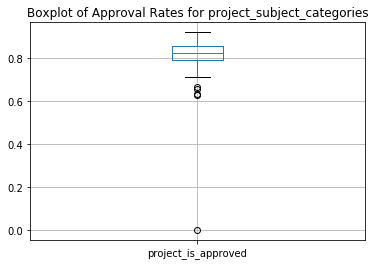

In [109]:
train_data_raw[['project_subject_categories', 'project_is_approved']].groupby('project_subject_categories').mean().sort_values(by='project_is_approved', ascending=False).boxplot();
plt.title("Boxplot of Approval Rates for project_subject_categories");

As project_subject_subcategories has a huge number of combinations, only the first 30 entries for number of proposals is shown. There is a large variance in proposals for subcategories. The full set of subcategories is shown for approval rates. There is a large variance in approval rates here. Note that the subcategories with highest (100% approval rate) and lowest (0% approval rate) only had one submission each.

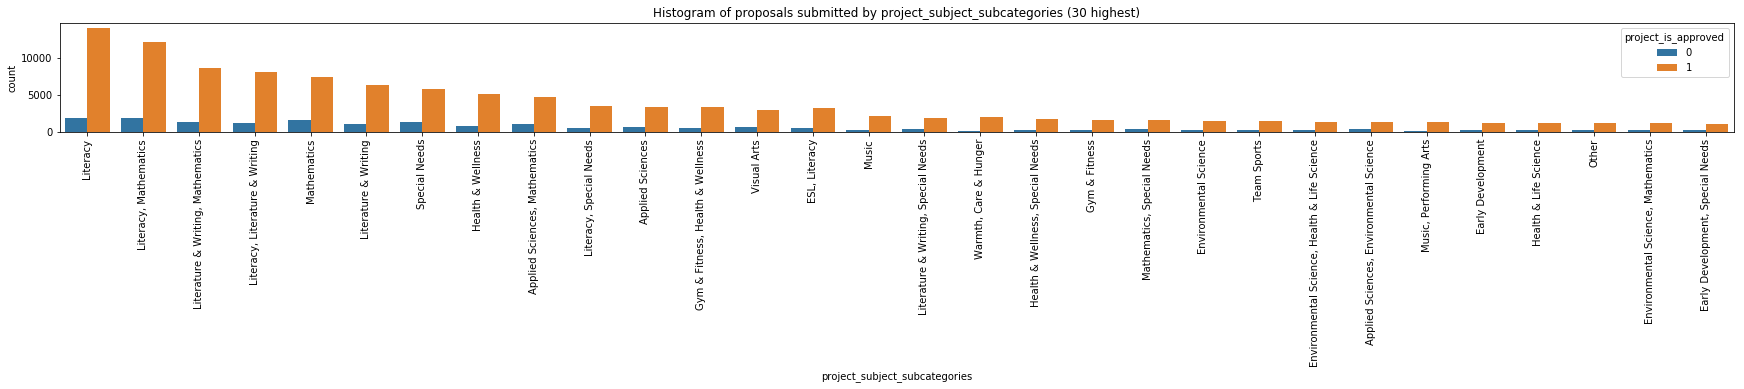

In [110]:
plt.figure(figsize=(30,2))
sns.countplot(x=train_data_raw['project_subject_subcategories'], hue=train_data_raw['project_is_approved'], order=train_data_raw['project_subject_subcategories'].value_counts().iloc[:30].index);
plt.xticks(rotation=90);
plt.title('Histogram of proposals submitted by project_subject_subcategories (30 highest)');

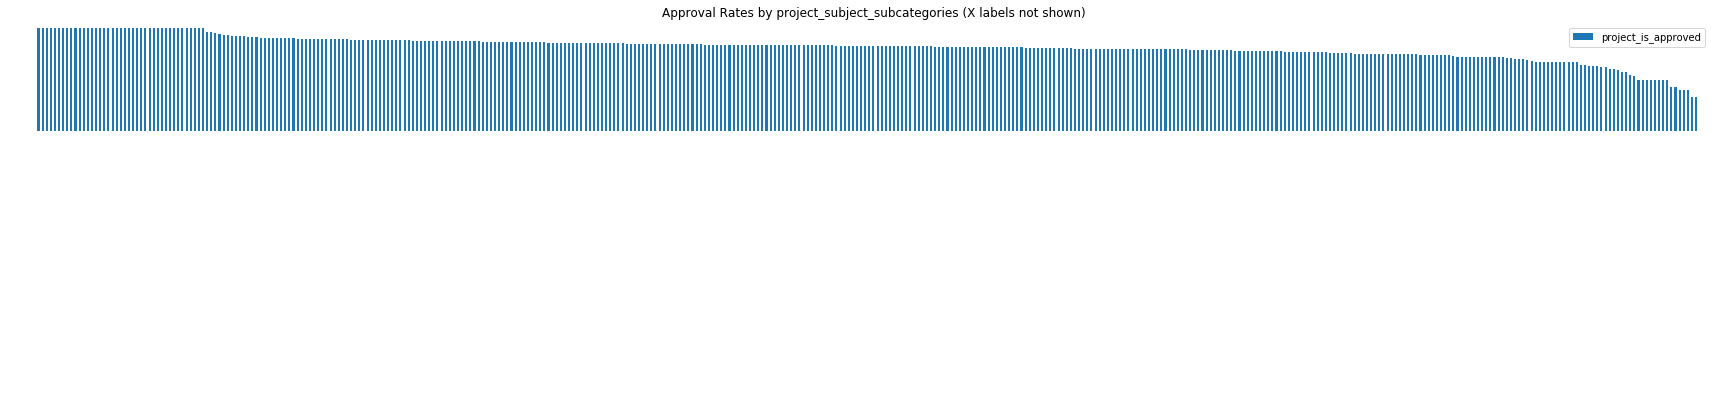

In [111]:
train_data_raw[['project_subject_subcategories', 'project_is_approved']].groupby('project_subject_subcategories').mean().sort_values(by='project_is_approved', ascending=False).plot.bar(figsize=(30,2), grid=True, title='Approval Rates by project_subject_subcategories (X labels not shown)');
plt.axis('off')
plt.show()

In [112]:
train_data_raw[['project_subject_subcategories', 'project_is_approved']].groupby('project_subject_subcategories')['project_is_approved'].agg(['mean','count']).sort_values('mean', ascending=False).head(60)

,mean,count
project_subject_subcategories,,
"Financial Literacy, Foreign Languages",1.000000,1
"Financial Literacy, Health & Wellness",1.000000,2
"Gym & Fitness, Social Sciences",1.000000,1
"Gym & Fitness, Parent Involvement",1.000000,2
"Character Education, Nutrition Education",1.000000,3
"Foreign Languages, Parent Involvement",1.000000,3
"Financial Literacy, Social Sciences",1.000000,4
"Financial Literacy, Performing Arts",1.000000,2
"Financial Literacy, Parent Involvement",1.000000,2


In [113]:
train_data_raw[['project_subject_subcategories', 'project_is_approved']].groupby('project_subject_subcategories')['project_is_approved'].agg(['mean','count']).sort_values('mean', ascending=False).tail(60)

,mean,count
project_subject_subcategories,,
"ESL, Parent Involvement",0.722222,18
"Environmental Science, Extracurricular",0.722222,18
"Community Service, Extracurricular",0.720000,25
"College & Career Prep, Performing Arts",0.718750,32
"Community Service, Health & Wellness",0.714286,21
"Environmental Science, Warmth, Care & Hunger",0.714286,7
"Early Development, Financial Literacy",0.714286,7
"Performing Arts, Team Sports",0.714286,21
"Gym & Fitness, Literacy",0.714286,70


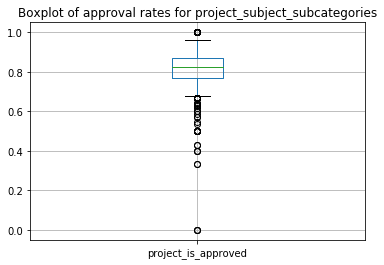

In [114]:
train_data_raw[['project_subject_subcategories', 'project_is_approved']].groupby('project_subject_subcategories').mean().sort_values(by='project_is_approved', ascending=False).boxplot(whis=1);
plt.title("Boxplot of approval rates for project_subject_subcategories");

There is some variance in the number of proposals across grade categories, but the approval rate is similar for each

Text(0.5,1,'Histogram of proposals submitted by project_grade_category')

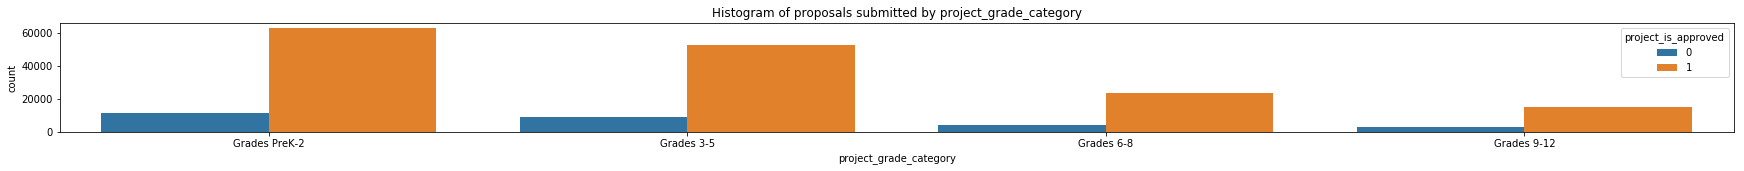

In [115]:
plt.figure(figsize=(30,2))
sns.countplot(x=train_data_raw['project_grade_category'], hue=train_data_raw['project_is_approved'], order=train_data_raw['project_grade_category'].value_counts().index);
plt.title('Histogram of proposals submitted by project_grade_category')

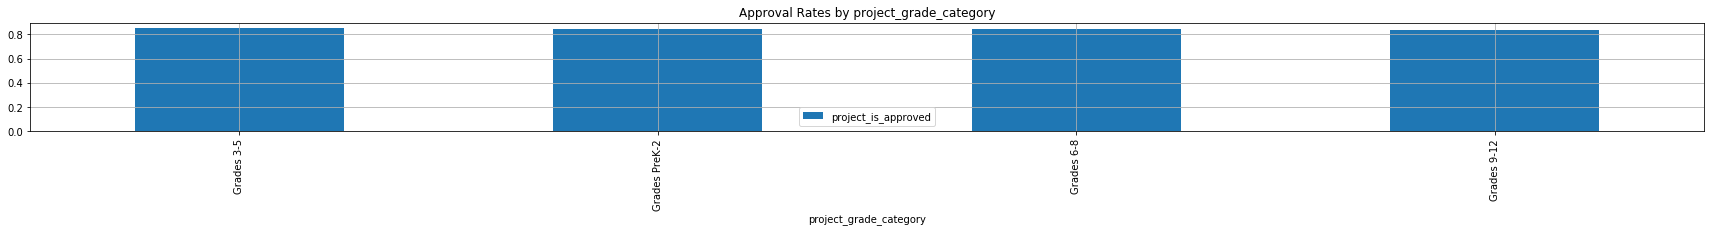

In [116]:
train_data_raw[['project_grade_category', 'project_is_approved']].groupby('project_grade_category').mean().sort_values(by='project_is_approved', ascending=False).plot.bar(figsize=(30,2), grid=True, title='Approval Rates by project_grade_category');

There is some variance across teacher prefixes, but the approval rates are mostly similar.

Text(0.5,1,'Histogram of proposals submitted by teacher_prefix')

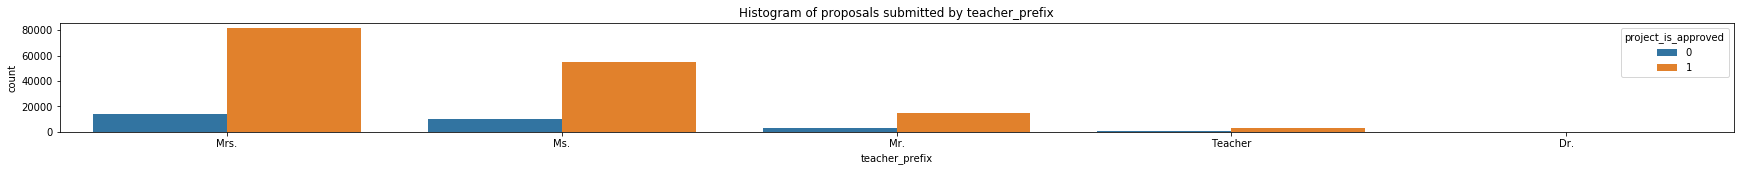

In [117]:
plt.figure(figsize=(30,2))
sns.countplot(x=train_data_raw['teacher_prefix'], hue=train_data_raw['project_is_approved'], order=train_data_raw['teacher_prefix'].value_counts().index);
plt.title('Histogram of proposals submitted by teacher_prefix')

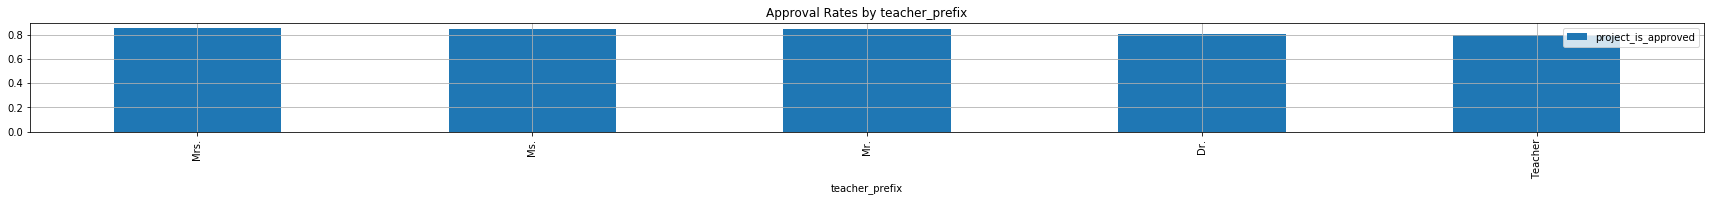

In [118]:
train_data_raw[['teacher_prefix', 'project_is_approved']].groupby('teacher_prefix').mean().sort_values(by='project_is_approved', ascending=False).plot.bar(figsize=(30,2), grid=True, title='Approval Rates by teacher_prefix');

**EDA of text features**

The description feature in the resources dataset has NAN values for 292 entries. However, the quantity and price fields are still good. We wll fill these NAN descriptions with empty text.

In [119]:
resource_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541272 entries, 0 to 1541271
Data columns (total 5 columns):
id             1541272 non-null object
description    1540980 non-null object
quantity       1541272 non-null int64
price          1541272 non-null float64
total          1541272 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 58.8+ MB


In [120]:
resource_data_raw[resource_data_raw.isnull().any(axis=1)].head()

,id,description,quantity,price,total
37603,p194324,NaN,1,73.16,73.16
37604,p194324,NaN,1,11.69,11.69
37605,p194324,NaN,1,64.30,64.30
37606,p194324,NaN,1,15.52,15.52
44304,p084588,NaN,1,44.38,44.38


In [121]:
resource_data_raw.fillna('', inplace=True)
resource_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541272 entries, 0 to 1541271
Data columns (total 5 columns):
id             1541272 non-null object
description    1541272 non-null object
quantity       1541272 non-null int64
price          1541272 non-null float64
total          1541272 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 58.8+ MB


Concatenate all of the descriptions for each proposal id together into a pivot table, which will then be merged into the test and training datasets

In [122]:
pivot_table = resource_data_raw.groupby('id').description.apply(lambda x: "%s" % ';'.join(x)).reset_index()

In [123]:
train_data_raw = train_data_raw.merge(pivot_table, on='id')
test_data_raw = test_data_raw.merge(pivot_table, on='id')

Many of the project_essay_3 and project_essay_4 entries are NAN. This is expected for submissions after May 17, 2016. Since the old essays 1&2 and 3&4 are similar to new essays 1 and 2 respectively, let's then concatenate the essays then drop columns 3 and 4

In [124]:
essay_3_4_nonull_filter = train_data_raw.project_essay_3.notnull()

train_data_raw.loc[essay_3_4_nonull_filter,'project_essay_1'] = train_data_raw[essay_3_4_nonull_filter].project_essay_1.str.cat(train_data_raw[essay_3_4_nonull_filter].project_essay_2)
train_data_raw.loc[essay_3_4_nonull_filter, 'project_essay_2'] = train_data_raw[essay_3_4_nonull_filter].project_essay_3.str.cat(train_data_raw[essay_3_4_nonull_filter].project_essay_4)

train_data_raw.drop(['project_essay_3', 'project_essay_4'], axis=1, inplace=True)

test_essay_3_4_nonull_filter = test_data_raw.project_essay_3.notnull()

test_data_raw.loc[test_essay_3_4_nonull_filter,'project_essay_1'] = test_data_raw[test_essay_3_4_nonull_filter].project_essay_1.str.cat(test_data_raw[test_essay_3_4_nonull_filter].project_essay_2)
test_data_raw.loc[test_essay_3_4_nonull_filter, 'project_essay_2'] = test_data_raw[test_essay_3_4_nonull_filter].project_essay_3.str.cat(test_data_raw[test_essay_3_4_nonull_filter].project_essay_4)

test_data_raw.drop(['project_essay_3', 'project_essay_4'], axis=1, inplace=True)

In [125]:
train_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182076 entries, 0 to 182075
Data columns (total 24 columns):
id                                              182076 non-null object
teacher_id                                      182076 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182076 non-null object
project_submitted_datetime                      182076 non-null datetime64[ns]
project_grade_category                          182076 non-null object
project_subject_categories                      182076 non-null object
project_subject_subcategories                   182076 non-null object
project_title                                   182076 non-null object
project_essay_1                                 182076 non-null object
project_essay_2                                 182076 non-null object
project_resource_summary                        182076 non-null object
teacher_number_of_previously_

Collect some stats on the max and mean length of the text features

In [126]:
text_features_final = ['project_title', 'project_essay_1', 'project_essay_2', 'project_resource_summary', 'description']

str_df_approved = pd.DataFrame()
for col in text_features_final:
    str_df_approved[col] = train_data_raw[train_data_raw.project_is_approved==1][col].str.len()
    
str_df_rejected = pd.DataFrame()
for col in text_features_final:
    str_df_rejected[col] = train_data_raw[train_data_raw.project_is_approved==0][col].str.len()

In [127]:
str_stats_approved_df = pd.DataFrame()
for col in str_df_approved:
    str_stats_approved_df[col] = str_df_approved[col].agg(['min', 'max', 'mean'])

str_stats_rejected_df = pd.DataFrame()
for col in str_df_rejected:
    str_stats_rejected_df[col] = str_df_rejected[col].agg(['min', 'max', 'mean'])

In [128]:
str_stats_approved_df

,project_title,project_essay_1,project_essay_2,project_resource_summary,description
min,5.0000,311.000000,435.00000,25.000000,2.000000
max,141.0000,2760.000000,5224.00000,902.000000,7215.000000
mean,32.5191,682.731415,857.82003,121.400254,299.922685


In [129]:
str_stats_rejected_df

,project_title,project_essay_1,project_essay_2,project_resource_summary,description
min,4.000000,169.000000,248.000000,25.000000,3.000000
max,102.000000,1523.000000,2262.000000,301.000000,5544.000000
mean,32.171775,675.563316,792.691209,127.300606,450.208805


In [130]:
train_data_raw[['project_is_approved', 'project_title']].groupby('project_is_approved').describe()

project_title                               
                            count  unique               top freq
project_is_approved                                             
0                           27734   26598  Flexible Seating   79
1                          154342  139990  Flexible Seating  298

In [131]:
from sklearn.feature_extraction.text import CountVectorizer

In [132]:
corpus = train_data_raw.project_essay_1
vec = CountVectorizer(stop_words='english').fit(corpus)
bag_of_words = vec.transform(corpus)
sum_words = bag_of_words.sum(axis=0) 
full_words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
full_words_freq = sorted(full_words_freq, key = lambda x: x[1], reverse=True)

In [133]:
corpus = train_data_raw[train_data_raw.project_is_approved==1].project_essay_1
vec = CountVectorizer(stop_words='english').fit(corpus)
bag_of_words = vec.transform(corpus)
sum_words = bag_of_words.sum(axis=0) 
approved_words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
approved_words_freq = sorted(approved_words_freq, key = lambda x: x[1], reverse=True)

In [134]:
corpus = train_data_raw[train_data_raw.project_is_approved==0].project_essay_1
vec = CountVectorizer(stop_words='english').fit(corpus)
bag_of_words = vec.transform(corpus)
sum_words = bag_of_words.sum(axis=0) 
rejected_words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
rejected_words_freq = sorted(rejected_words_freq, key = lambda x: x[1], reverse=True)

In [135]:
full_list_x = [x for x,y in full_words_freq[0:20]]
full_list_y = [y for x,y in full_words_freq[0:20]]

approved_list_x = [x for x,y in approved_words_freq[0:20]]
approved_list_y = [y for x,y in approved_words_freq[0:20]]

rejected_list_x = [x for x,y in rejected_words_freq[0:20]]
rejected_list_y = [y for x,y in rejected_words_freq[0:20]]

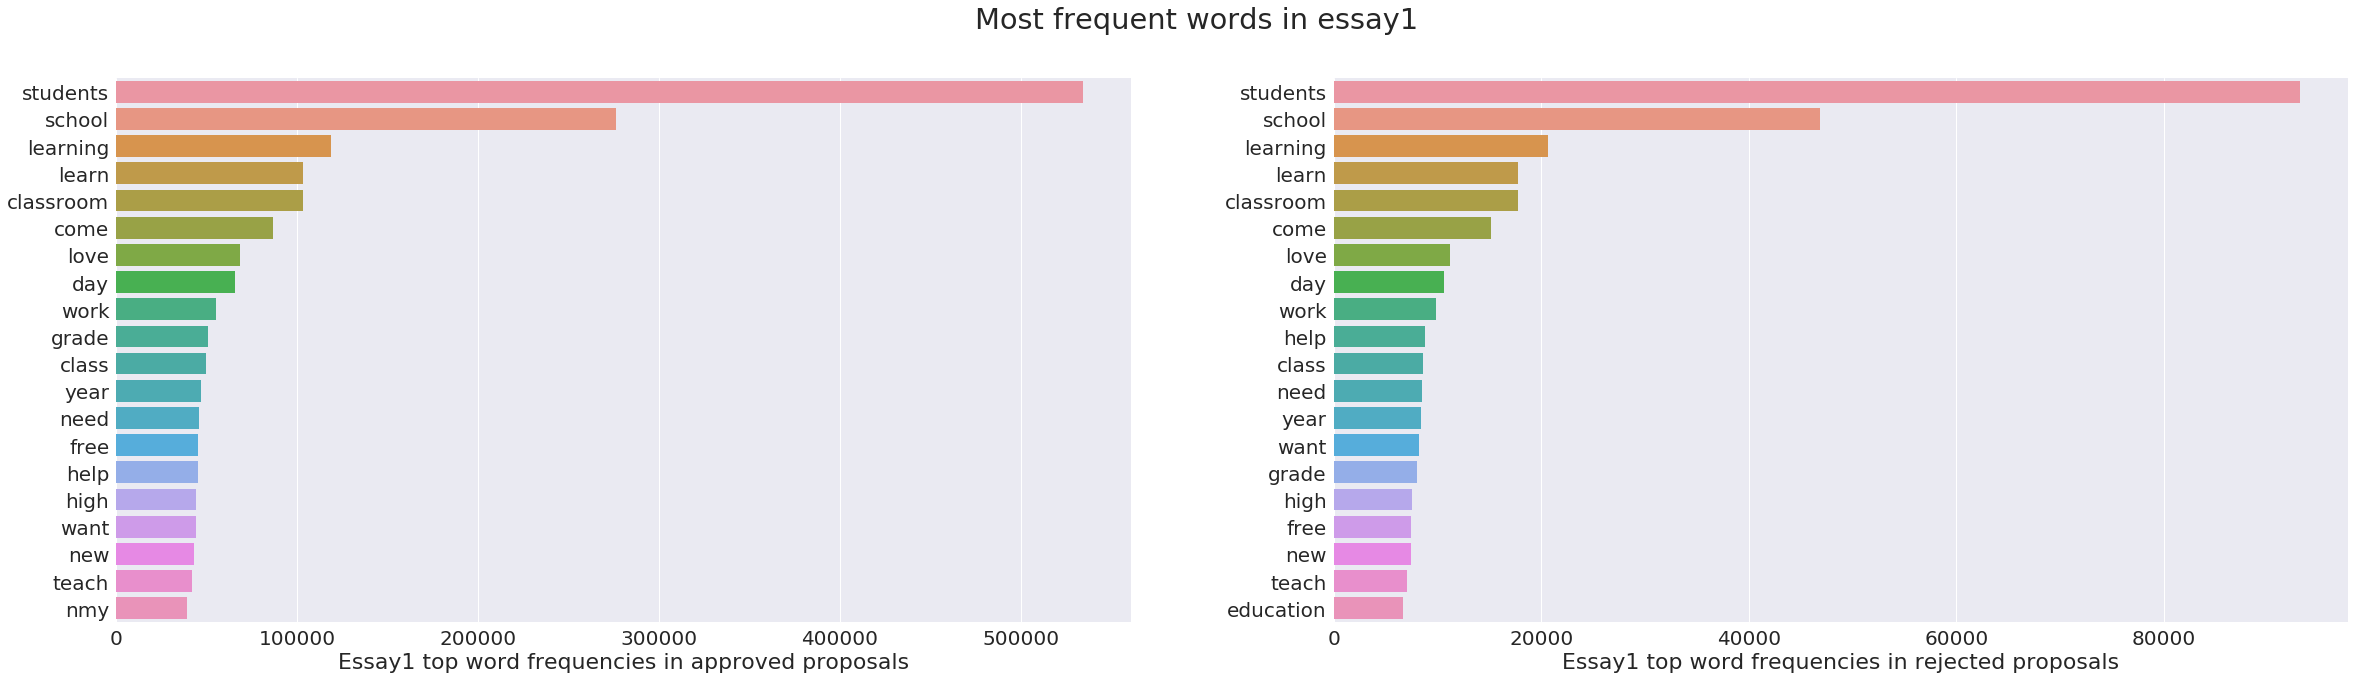

In [136]:
#plt.figure(figsize=(40,10))
sns.set(font_scale=2);
f, (ax2, ax3) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(40,10));
#sns.barplot(x=full_list_y, y=full_list_x, ax=ax1);
#ax1.set(xlabel='Word densities for ')
sns.barplot(x=approved_list_y, y=approved_list_x, ax=ax2);
ax2.set(xlabel="Essay1 top word frequencies in approved proposals");
sns.barplot(x=rejected_list_y, y=rejected_list_x, ax=ax3);
ax3.set(xlabel="Essay1 top word frequencies in rejected proposals");
plt.suptitle('Most frequent words in essay1');

In [137]:
str_df_charachters = pd.DataFrame()
str_df_charachters['project_is_approved'] = train_data_raw.project_is_approved
for col in text_features_final:
    str_df_charachters[col] = train_data_raw[col].str.len()

In [138]:
str_df_num_words = pd.DataFrame()
str_df_num_words['project_is_approved'] = train_data_raw.project_is_approved
for col in text_features_final:
    str_df_num_words[col] = train_data_raw[col].str.split().str.len()

In [139]:
str_df_word_density = pd.DataFrame()
str_df_word_density['project_is_approved'] = train_data_raw.project_is_approved
for col in text_features_final:
    str_df_word_density[col] =  str_df_num_words[col] / str_df_charachters[col]

In [140]:
str_df_word_density.head()

,project_is_approved,project_title,project_essay_1,project_essay_2,project_resource_summary,description
0,1,0.166667,0.175801,0.176398,0.165354,0.181208
1,0,0.227273,0.153322,0.156495,0.148148,0.185714
2,1,0.190476,0.174770,0.184982,0.177419,0.166667
3,0,0.138889,0.164030,0.156328,0.154506,0.155405
4,1,0.187500,0.177384,0.188849,0.169014,0.184615


In [141]:
str_df_word_density.groupby('project_is_approved').agg(['min', 'max', 'mean'])

project_title                     project_essay_1  \
                              min       max      mean             min   
project_is_approved                                                     
0                        0.024390  0.454545  0.160307        0.106860   
1                        0.019608  0.416667  0.162444        0.031493   

                                        project_essay_2                      \
                          max      mean             min       max      mean   
project_is_approved                                                           
0                    0.491124  0.168667        0.102041  0.407258  0.166979   
1                    0.212202  0.168522        0.022481  0.214876  0.167607   

                    project_resource_summary                     description  \
                                         min       max      mean         min   
project_is_approved                                                            
0                                   0.099010  0.240000  0.164467    0.044118   
1                                   0.065574  0.254902  0.166372    0.009009   

                                         
                          max      mean  
project_is_approved                      
0                    0.333333  0.153508  
1                    0.500000  0.159732

Explore some visualizations for the Free-Form Visualization section of the Capstone Report

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


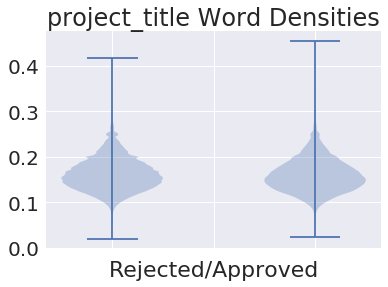

In [142]:
fig, axes = plt.subplots();
axes.violinplot(dataset=[str_df_word_density[str_df_word_density.project_is_approved==1]['project_title'], str_df_word_density[str_df_word_density.project_is_approved==0]['project_title']]);
axes.set_title('project_title Word Densities');
axes.yaxis.grid(True);
axes.set_xlabel('Rejected/Approved');
axes.set_ylabel('');
axes.set_xticklabels([]);

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


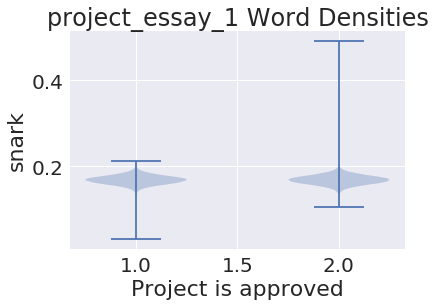

In [143]:
fig, axes = plt.subplots();
axes.violinplot(dataset=[str_df_word_density[str_df_word_density.project_is_approved==1]['project_essay_1'], str_df_word_density[str_df_word_density.project_is_approved==0]['project_essay_1']]);
axes.set_title('project_essay_1 Word Densities');
axes.yaxis.grid(True);
axes.set_xlabel('Project is approved');
axes.set_ylabel('snark');

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


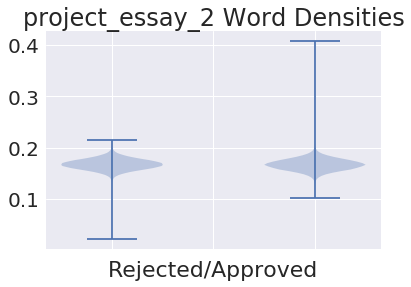

In [144]:
fig, axes = plt.subplots();
axes.violinplot(dataset=[str_df_word_density[str_df_word_density.project_is_approved==1]['project_essay_2'], str_df_word_density[str_df_word_density.project_is_approved==0]['project_essay_2']]);
axes.set_title('project_essay_2 Word Densities');
axes.yaxis.grid(True);
axes.set_xlabel('Rejected/Approved');
axes.set_ylabel('');
axes.set_xticklabels([]);

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


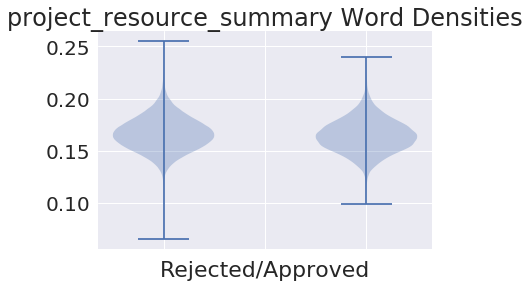

In [145]:
fig, axes = plt.subplots();
axes.violinplot(dataset=[str_df_word_density[str_df_word_density.project_is_approved==1]['project_resource_summary'], str_df_word_density[str_df_word_density.project_is_approved==0]['project_resource_summary']]);
axes.set_title('project_resource_summary Word Densities');
axes.yaxis.grid(True);
axes.set_xlabel('Rejected/Approved');
axes.set_ylabel('');
axes.set_xticklabels([]);

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


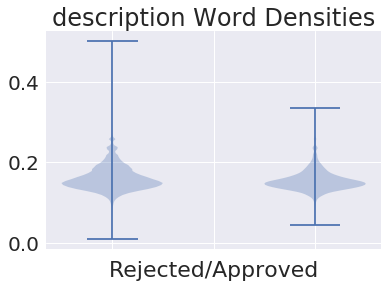

In [146]:
fig, axes = plt.subplots();
axes.violinplot(dataset=[str_df_word_density[str_df_word_density.project_is_approved==1]['description'], str_df_word_density[str_df_word_density.project_is_approved==0]['description']]);
axes.set_title('description Word Densities');
axes.yaxis.grid(True);
axes.set_xlabel('Rejected/Approved');
axes.set_ylabel('');
axes.set_xticklabels([]);

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


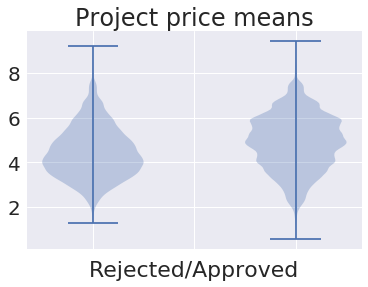

In [147]:
fig, axes = plt.subplots();
axes.violinplot(dataset=[np.log(train_data_raw[train_data_raw.project_is_approved==0]['mean']), np.log(train_data_raw[train_data_raw.project_is_approved==1]['mean'])]);
axes.set_title('Project price means');
axes.yaxis.grid(True);
axes.set_xlabel('Rejected/Approved');
axes.set_ylabel('');
axes.set_xticklabels([]);

In [148]:
approval_rates_by_month = train_data_raw[['project_is_approved', 'month']].groupby('month').mean().reset_index()
approval_rates_by_month

,month,project_is_approved
0,01,0.851864
1,02,0.861565
2,03,0.860227
3,04,0.846140
4,05,0.866182
5,06,0.858674
6,07,0.828164
7,08,0.842471
8,09,0.822424
9,10,0.846338


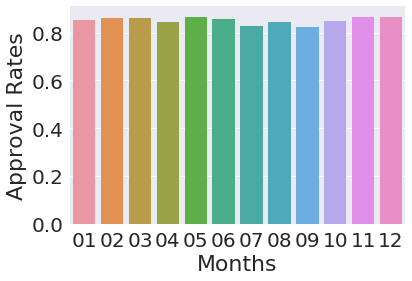

In [149]:
ax1 = sns.barplot(x=approval_rates_by_month.month, y=approval_rates_by_month.project_is_approved)
ax1.set(xlabel='Months', ylabel='Approval Rates');

In [150]:
approval_rates_by_subcategory = train_data_raw[['project_subject_subcategories', 'project_is_approved']].groupby('project_subject_subcategories').mean().reset_index()
submission_counts_by_subcategory = train_data_raw[['project_subject_subcategories', 'project_is_approved']].groupby('project_subject_subcategories').count().reset_index()
subcategory_df = approval_rates_by_subcategory.merge(submission_counts_by_subcategory, on='project_subject_subcategories')
subcategory_df = subcategory_df.sort_values(by='project_is_approved_x', ascending=True)

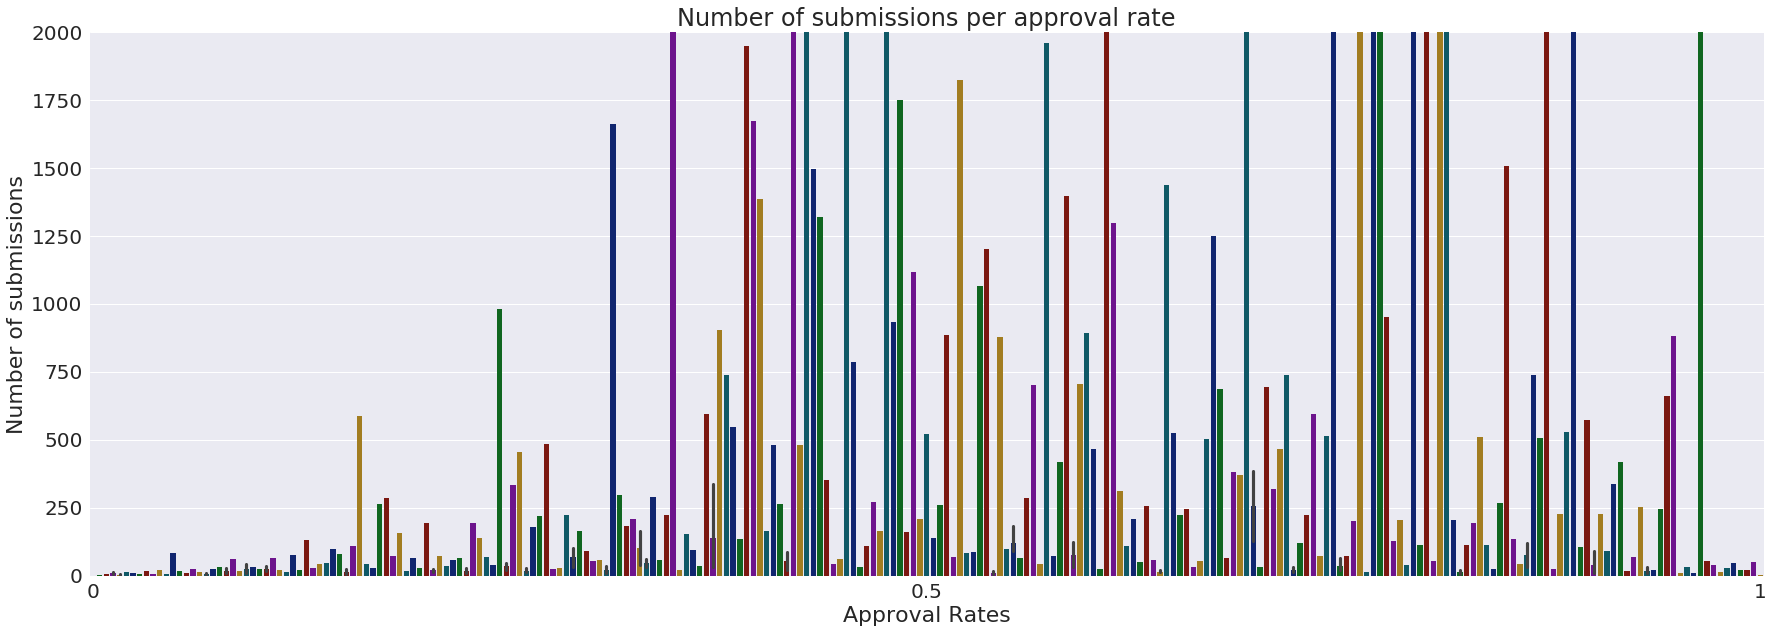

In [151]:
plt.figure(figsize=(30,10));
ax1 = sns.barplot(x=subcategory_df.project_is_approved_x, y=subcategory_df.project_is_approved_y, palette='dark');
plt.ylim(0,2000)
labels = [item.get_text() for item in ax1.get_xticklabels()]
for i in range(len(labels)):
    labels[i]=''
labels[0]=0
labels[-1] = 1
halfwaythere = len(labels)//2
labels[halfwaythere] = .5
ax1.set_xticklabels(labels);
ax1.set(ylabel='Number of submissions', xlabel='Approval Rates')

ax1.set_title('Number of submissions per approval rate');
axes.yaxis.grid(True);

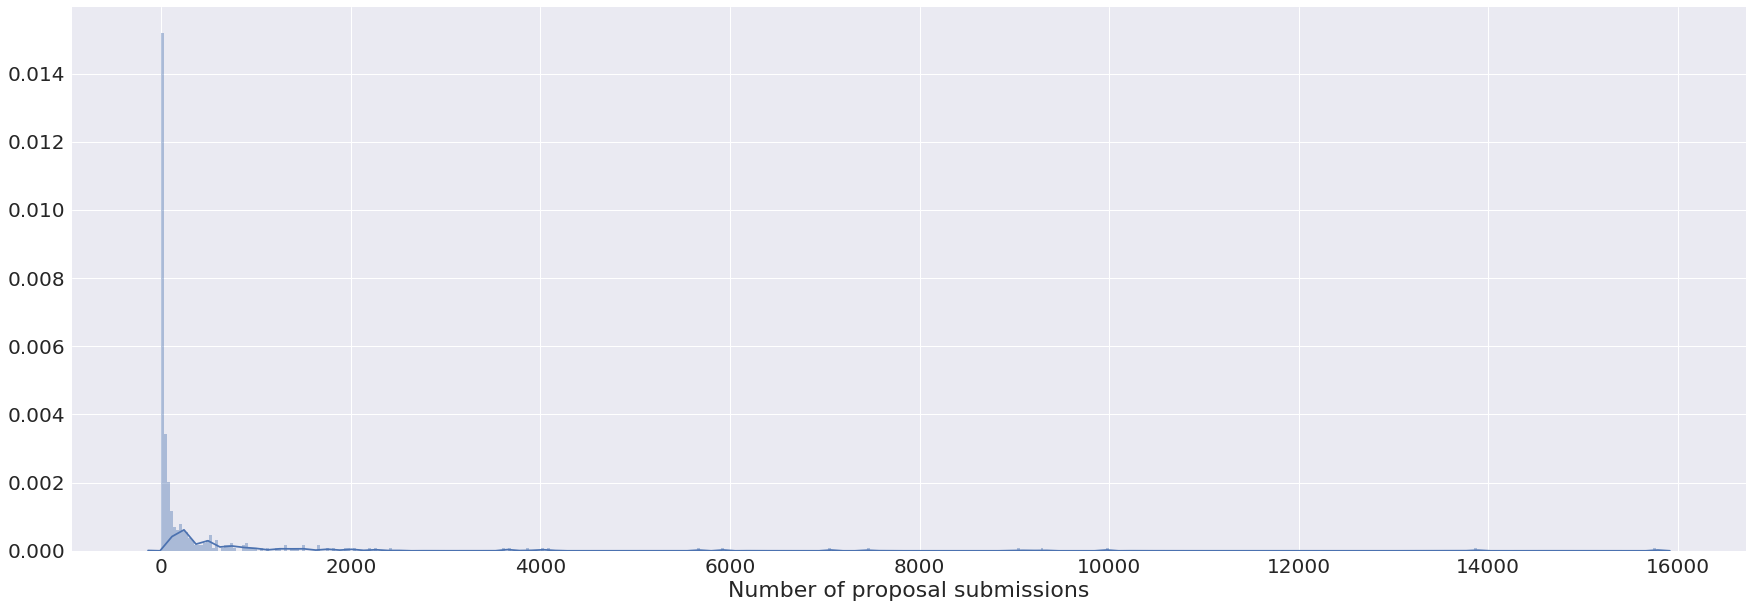

In [152]:
plt.figure(figsize=(30,10));
axes = sns.distplot(subcategory_df.project_is_approved_y, bins=500);
axes.set(xlabel='Number of proposal submissions', ylabel='');

Text(0.5,1,'Histogram of number of proposals submitted by project_subject_subcategories')

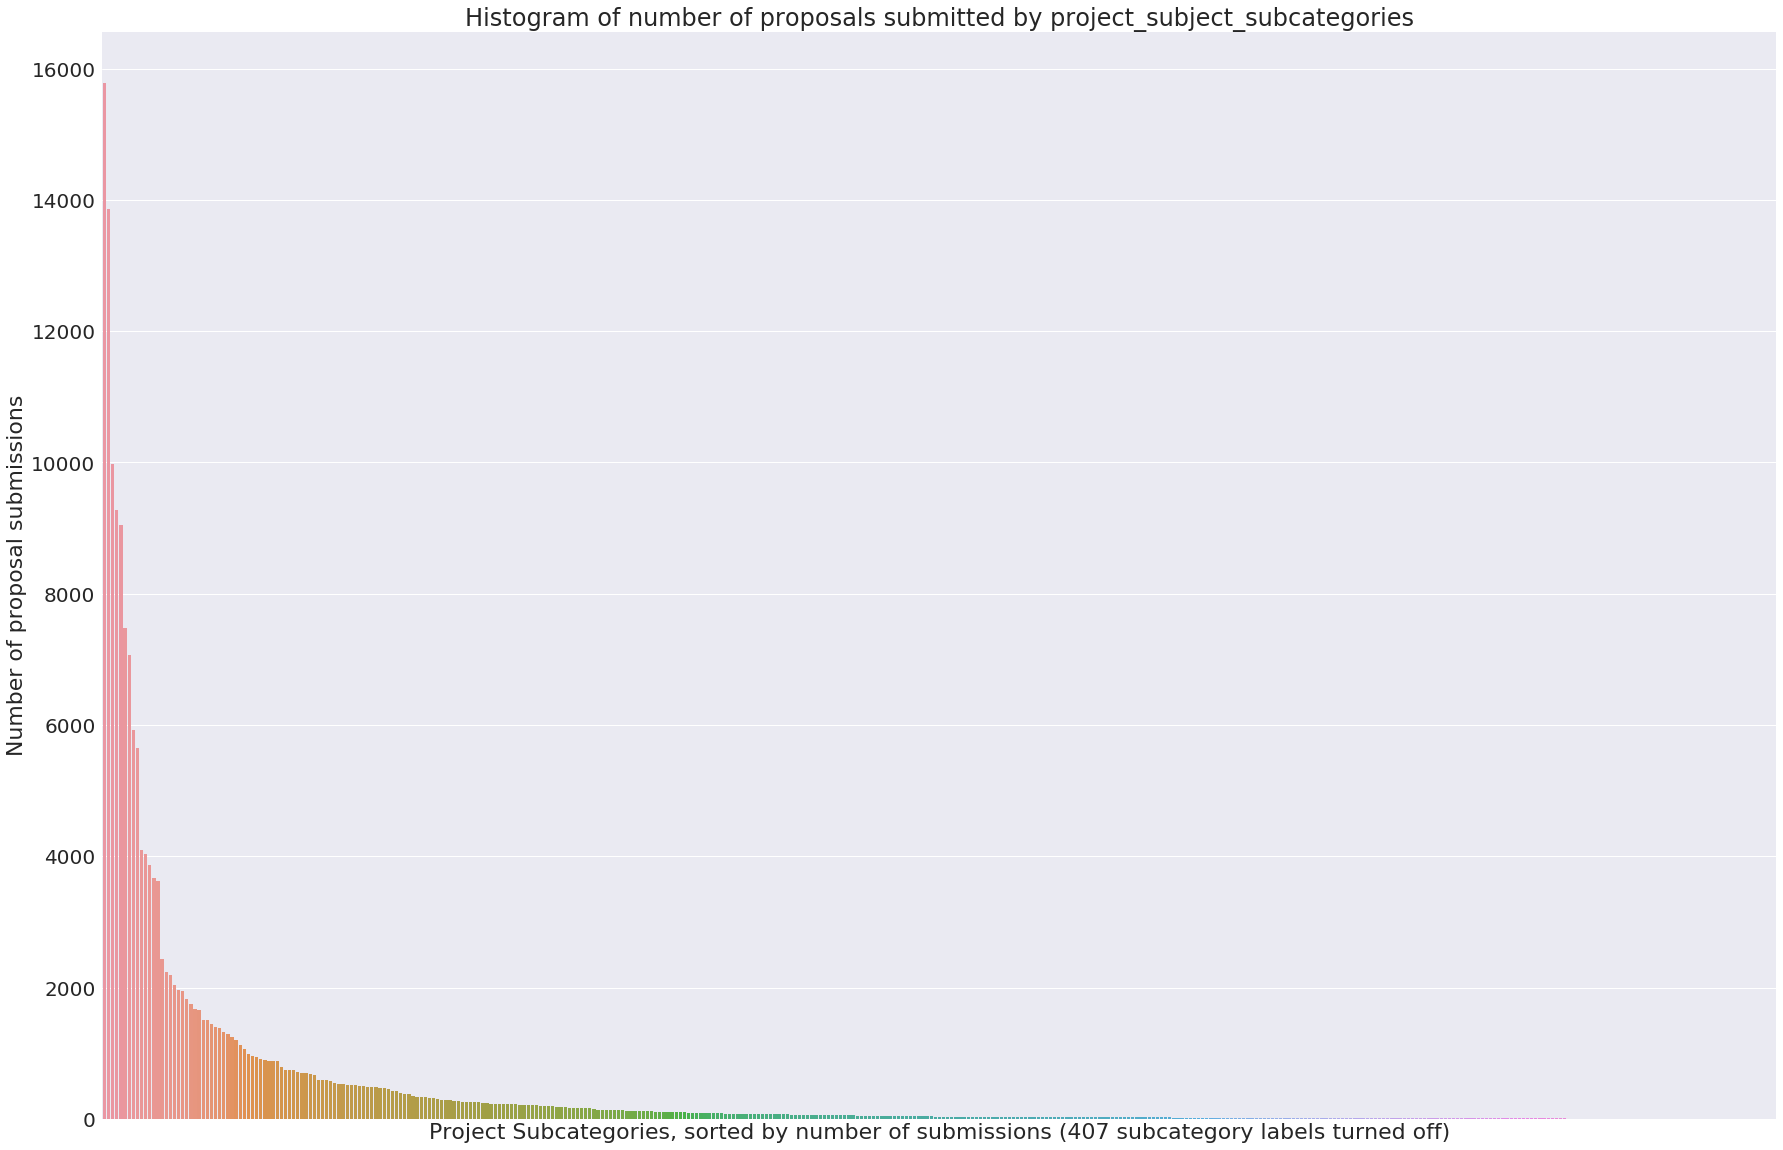

In [153]:
plt.figure(figsize=(30,20))
g = sns.countplot(x=train_data_raw['project_subject_subcategories'], order=train_data_raw['project_subject_subcategories'].value_counts().index);
#g.set_yscale('log')
g.set(xlabel='Project Subcategories, sorted by number of submissions (407 subcategory labels turned off)', ylabel='Number of proposal submissions')
plt.xticks([]);
plt.title('Histogram of number of proposals submitted by project_subject_subcategories')

In [154]:
print("Categories with 10 lowest approval rates, and the number of submissions for those subcategories")
subcategory_df[:10]

Categories with 10 lowest approval rates, and the number of submissions for those subcategories


,project_subject_subcategories,project_is_approved_x,project_is_approved_y
129,"ESL, Economics",0.000000,1
320,"History & Geography, Warmth, Care & Hunger",0.000000,1
229,"Extracurricular, Warmth, Care & Hunger",0.000000,1
63,"Civics & Government, Extracurricular",0.333333,3
28,"Applied Sciences, Warmth, Care & Hunger",0.333333,3
187,"Economics, Special Needs",0.400000,5
376,"Other, Performing Arts",0.400000,5
221,"Extracurricular, Nutrition Education",0.400000,5
121,"Community Service, Other",0.428571,14
56,"Character Education, Warmth, Care & Hunger",0.428571,7


In [155]:
print("Categories with 50 highest approval rates, and the number of submissions for those subcategories")
subcategory_df[-50:]

Categories with 50 highest approval rates, and the number of submissions for those subcategories


,project_subject_subcategories,project_is_approved_x,project_is_approved_y
406,"Warmth, Care & Hunger",0.921953,2191
387,"Parent Involvement, Visual Arts",0.924528,53
218,"Extracurricular, Literature & Writing",0.925000,40
234,"Financial Literacy, History & Geography",0.928571,14
224,"Extracurricular, Performing Arts",0.931034,29
100,"College & Career Prep, Social Sciences",0.937500,48
141,"ESL, Music",0.952381,21
64,"Civics & Government, Financial Literacy",0.956522,23
312,"History & Geography, Music",0.961538,52
72,"Civics & Government, Nutrition Education",1.000000,1


In [156]:
len(subcategory_df)

407

In [157]:
subcategory_base_values = sorted(train_data_raw[~train_data_raw.project_subject_subcategories.str.contains(',')].project_subject_subcategories.unique(), key=len)

In [158]:
import operator

subcat_dict = {}
for subcat in subcategory_base_values:
    subcat_dict[subcat] = train_data_raw[train_data_raw.project_subject_subcategories.str.contains(subcat)][['project_is_approved', 'project_subject_subcategories']].project_is_approved.count()                     

subcat_list = sorted(subcat_dict.items(), key=operator.itemgetter(1))         
#train_data_raw[['school_state', 'project_is_approved']].groupby('school_state').mean()
#subcat_df = pd.DataFrame.from_dict(subcat_dict, orient='index').reset_index()
#subcat_df.columns=['project_subject_subcategories', 'num_submissions']

subcat_approval_rate_dict = {}
for subcat in subcategory_base_values:
    subcat_approval_rate_dict[subcat] = train_data_raw[train_data_raw.project_subject_subcategories.str.contains(subcat)][['project_is_approved', 'project_subject_subcategories']].project_is_approved.mean()                     

subcat_approval_rate_list = sorted(subcat_approval_rate_dict.items(), key=operator.itemgetter(1)) 

In [159]:
subcat_df = pd.DataFrame(subcat_list, columns=['project_subject_subcategories', 'num_submissions'])
subcat_df

,project_subject_subcategories,num_submissions
0,Economics,431
1,Community Service,712
2,Financial Literacy,956
3,Parent Involvement,1103
4,Civics & Government,1294
5,Extracurricular,1332
6,Foreign Languages,1496
7,Nutrition Education,2236
8,Social Sciences,3149
9,Performing Arts,3223


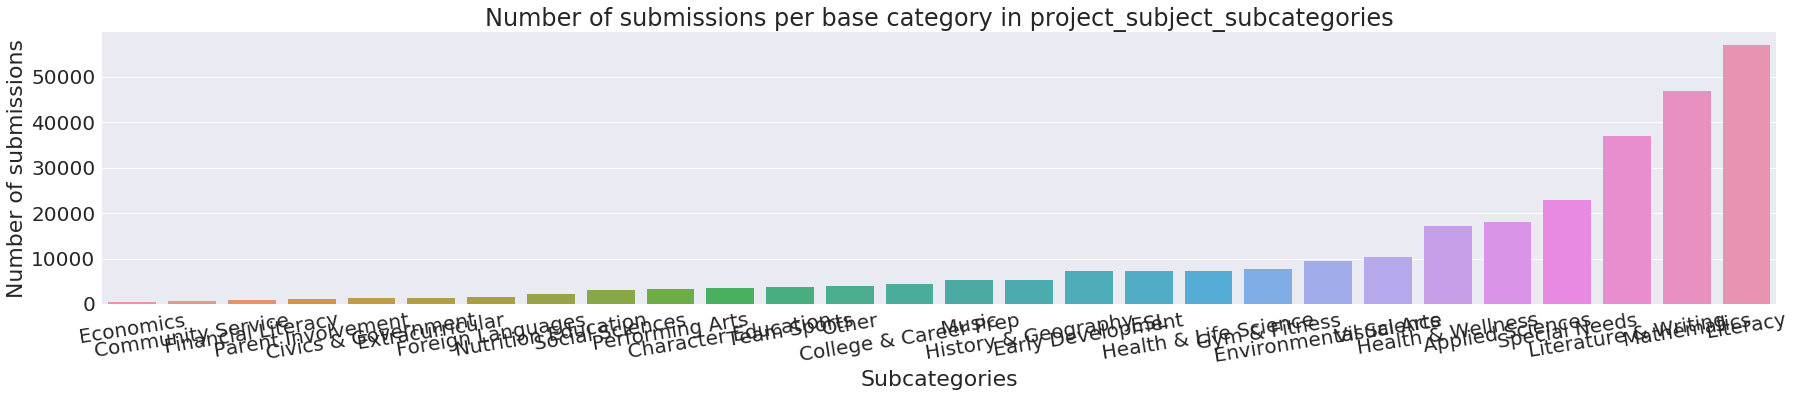

In [160]:
plt.figure(figsize=(30,5))
g = sns.barplot(x=subcat_df.project_subject_subcategories, y=subcat_df.num_submissions);
g.set(xlabel='Subcategories', ylabel='Number of submissions');
g.set_xticklabels(g.get_xticklabels(), rotation=9);
plt.title('Number of submissions per base category in project_subject_subcategories');

In [161]:
subcat_approval_rate_df = pd.DataFrame(subcat_approval_rate_list, columns=['project_subject_subcategories', 'approval_rates'])
subcat_approval_rate_df

,project_subject_subcategories,approval_rates
0,Community Service,0.768258
1,Team Sports,0.797145
2,Character Education,0.803069
3,Nutrition Education,0.811270
4,Extracurricular,0.816066
5,Visual Arts,0.817194
6,Economics,0.819026
7,Foreign Languages,0.820187
8,Early Development,0.824591
9,Environmental Science,0.824608


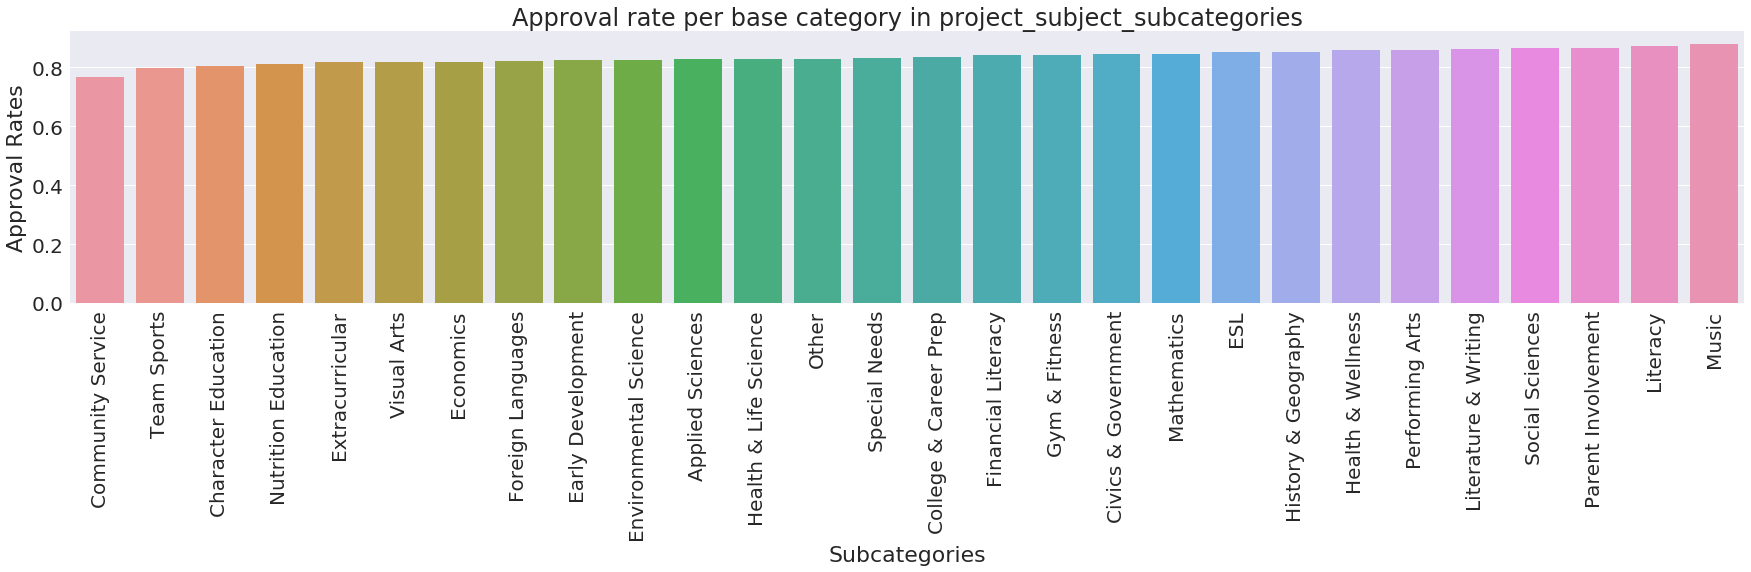

In [162]:
plt.figure(figsize=(30,5));
g = sns.barplot(x=subcat_approval_rate_df.project_subject_subcategories, y=subcat_approval_rate_df.approval_rates);
g.set(xlabel='Subcategories', ylabel='Approval Rates');
g.set_xticklabels(g.get_xticklabels(), rotation=90);
plt.title('Approval rate per base category in project_subject_subcategories');

In [163]:
subcat_df = subcat_df.merge(subcat_approval_rate_df, on='project_subject_subcategories')
subcat_df

,project_subject_subcategories,num_submissions,approval_rates
0,Economics,431,0.819026
1,Community Service,712,0.768258
2,Financial Literacy,956,0.841004
3,Parent Involvement,1103,0.864007
4,Civics & Government,1294,0.843122
5,Extracurricular,1332,0.816066
6,Foreign Languages,1496,0.820187
7,Nutrition Education,2236,0.811270
8,Social Sciences,3149,0.863449
9,Performing Arts,3223,0.857586
